## Instalar bibliotecas necesarias

In [ ]:
!pip install torch                    # Install the PyTorch library for deep learning.
!pip install pandas                   # Install the Pandas library for data manipulation.
!pip install scikit-learn             # Install scikit-learn for machine learning tasks.

## Acceder a drive

In [ ]:
from google.colab import drive

# Montar Google Drive en /content/drive
drive.mount('/content/drive')

# Listar archivos en el directorio raíz de Google Drive
!ls '/content/drive/MyDrive/Dataset/Dataset/Mosaico'

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision.io import read_image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime
from sklearn.preprocessing import StandardScaler

## Lectura de dataset train y test

In [2]:
# --> Desde local
train = pd.read_csv('../Dataset/Mosaico/train.csv')
test = pd.read_csv('../Dataset/Mosaico/test.csv')

# --> Desde google
# train = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset/Mosaico/train.csv')
# test = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset/Mosaico/test.csv')

train.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,5.0,5,3816,92880,284.png,589900
1,2.0,2,1440,92276,347.png,106000
2,3.0,4,1625,93510,440.png,639000
3,3.0,4,2454,93510,421.png,5858000
4,4.5,4,4038,92677,149.png,1795000


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bathrooms     428 non-null    float64
 1   bedrooms      428 non-null    int64  
 2   area          428 non-null    int64  
 3   zipcode       428 non-null    int64  
 4   mosaic_image  428 non-null    object 
 5   price         428 non-null    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 20.2+ KB


## Preparar Dataset

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Constructor de la clase que inicializa el dataset personalizado.
        df: DataFrame que contiene los datos (rutas de las imágenes y características numéricas).
        transform: Transformaciones opcionales que se aplicarán a las imágenes (si se proporciona).
        """
        self.df = df  # Guardar el DataFrame que contiene las rutas de imágenes y las características numéricas.
        self.transform = transform  # Almacenar las transformaciones opcionales para las imágenes.

        # Seleccionar las columnas que contienen las características numéricas que deseas estandarizar.
        self.numeric_features = ['bedrooms', 'bathrooms', 'area', 'zipcode']

        # Inicializar el estandarizador de sklearn (StandardScaler) y ajustarlo a las características numéricas.
        # Esto normaliza las características para que tengan media 0 y desviación estándar 1.
        self.scaler = StandardScaler()

        # Aplicar el estandarizador a las columnas de características numéricas y actualizar el DataFrame.
        # Las características numéricas se estandarizan y reemplazan en el DataFrame original.
        self.df[self.numeric_features] = self.scaler.fit_transform(self.df[self.numeric_features])

    def __len__(self):
        """
        Método que devuelve la longitud del dataset, es decir, el número de muestras en el DataFrame.
        """
        return len(self.df)

    def __getitem__(self, idx):
        """
        Método que obtiene una muestra del dataset en el índice `idx`.
        Este método es necesario para que el DataLoader pueda iterar sobre el dataset.
        idx: Índice de la muestra a recuperar.

        Devuelve:
        - La imagen procesada (como un tensor).
        - Las características numéricas estandarizadas (como un tensor).
        - El valor objetivo (precio), también convertido a tensor.
        """
        # Obtener la ruta de la imagen correspondiente al índice dado.
        img_path = self.df.loc[idx, 'mosaic_image']

        # Leer la imagen desde el disco utilizando torchvision.io.read_image.
        # Convierte la imagen en un tensor y ajusta su tipo de dato a flotante (float32).
        # mosaic_image = read_image(f"/content/drive/MyDrive/Dataset/Dataset/Mosaico/Imagenes/{img_path}").float()
        # Alternativamente, puedes leer la imagen desde otra ruta local.
        mosaic_image = read_image(f"../Dataset/Mosaico/Imagenes/{img_path}").float()

        # Obtener los valores de las características numéricas para la muestra actual.
        # Convertir estos valores en tensores de tipo float32.
        bathrooms = torch.tensor(self.df.loc[idx, 'bathrooms'], dtype=torch.float32)
        bedrooms = torch.tensor(self.df.loc[idx, 'bedrooms'], dtype=torch.float32)
        area = torch.tensor(self.df.loc[idx, 'area'], dtype=torch.float32)
        zipcode = torch.tensor(self.df.loc[idx, 'zipcode'], dtype=torch.float32)
        price = torch.tensor(self.df.loc[idx, 'price'], dtype=torch.float32)  # Precio como el valor objetivo.

        # Aplicar las transformaciones a la imagen si se proporcionaron en el constructor.
        if self.transform:
            mosaic_image = self.transform(mosaic_image)

        # Concatenar las características numéricas (bathrooms, bedrooms, area, zipcode) en un único tensor.
        # Utilizar torch.hstack para concatenar los tensores a lo largo del eje horizontal.
        numeric_features = torch.hstack((bathrooms, bedrooms, area, zipcode))

        # Devolver la imagen procesada, las características numéricas estandarizadas y el precio objetivo.
        return mosaic_image, numeric_features, price


## Aumentar datos

In [7]:
data1 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(224),                             # Asegura que todas las imágenes sean de 224x224 (si es necesario)
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),                    # Media para normalizar los canales RGB
        (85.9875, 82.3628, 80.8718)                     # Desviación estándar para normalizar
    )
]))

data2 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(224),
    # transforms.ColorJitter(
    #     brightness=0.3, contrast=0.3, saturation=0.3              # Ajustes moderados de color
    # ),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),    # Aplicar desenfoque gaussiano
    transforms.Normalize(
        (58.0583, 55.1679, 52.9831),
        (85.9875, 82.3628, 80.8718)
    )
]))

# data3 = CustomImageDataset(df=train, transform=transforms.Compose([
#     transforms.Resize(224),
#     # transforms.ColorJitter(
#     #     brightness=0.4, contrast=0.4, saturation=0.4    # Un poco más de variabilidad en los colores
#     # ),
#     transforms.Normalize(
#         (58.0583, 55.1679, 52.9831),
#         (85.9875, 82.3628, 80.8718)
#     )
# ]))

# data4 = CustomImageDataset(df=train, transform=transforms.Compose([
#     transforms.Resize(224),
#     # transforms.ColorJitter(
#     #     brightness=0.2, contrast=0.2, saturation=0.2    # Ajustes más conservadores
#     # ),
#     transforms.Normalize(
#         (58.0583, 55.1679, 52.9831),
#         (85.9875, 82.3628, 80.8718)
#     )
# ]))

# data5 = CustomImageDataset(df=train, transform=transforms.Compose([
#     transforms.Resize(224),
#     transforms.Normalize(
#         (58.0583, 55.1679, 52.9831),
#         (85.9875, 82.3628, 80.8718)
#     )
# ]))

# data6 = CustomImageDataset(df=train, transform=transforms.Compose([
#     transforms.Resize(224),
#     transforms.Normalize(
#         (58.0583, 55.1679, 52.9831),
#         (85.9875, 82.3628, 80.8718)
#     )
# ]))

# data7 = CustomImageDataset(df=train, transform=transforms.Compose([
#     transforms.Resize(224),
#     # transforms.ColorJitter(
#     #     brightness=0.3, contrast=0.3, saturation=0.3    # Variabilidad en el color, pero sin exagerar
#     # ),
#     transforms.Normalize(
#         (58.0583, 55.1679, 52.9831),
#         (85.9875, 82.3628, 80.8718)
#     )
# ]))


## Ver imagenes de cada data

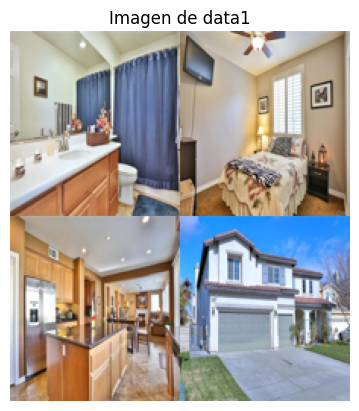

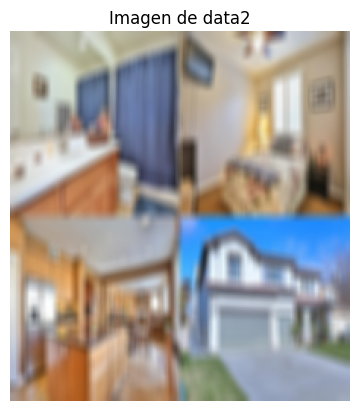

In [8]:
import matplotlib.pyplot as plt
import torch

# Función para deshacer la normalización (inverso de transforms.Normalize)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)  # Ajustar la media a la forma del tensor
    std = torch.tensor(std).view(3, 1, 1)    # Ajustar la desviación estándar a la forma del tensor
    return tensor * std + mean

# Función para mostrar una imagen
def show_image(image_tensor, title=None):
    # Deshacer la normalización
    image_tensor = denormalize(image_tensor, mean=(58.0583, 55.1679, 52.9831), std=(85.9875, 82.3628, 80.8718))
    
    # Asegurarse de que los valores de los píxeles estén entre 0 y 255
    image_tensor = torch.clamp(image_tensor, 0, 255)

    # Convertir el tensor a numpy
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia las dimensiones de (C, H, W) a (H, W, C)

    # Mostrar la imagen
    plt.imshow(image.astype('uint8'))  # Convertir los valores a uint8 para que matplotlib pueda mostrarlos correctamente
    if title:
        plt.title(title)
    plt.axis('off')  # Quitar los ejes
    plt.show()

# Visualizar la primera imagen de cada conjunto de datos
datasets = [data1, data2]
for i, dataset in enumerate(datasets, 1):
    # Obtener la primera muestra del conjunto de datos (imagen, características numéricas, precio)
    image, _, _ = dataset[0]
    
    # Mostrar la imagen
    show_image(image, title=f"Imagen de data{i}")


## Dividir en train y test

In [9]:
# Crear un conjunto de datos combinado
conjunto_datos = ConcatDataset((data1,data2))


In [10]:
# Determinar el tamaño de los conjuntos de entrenamiento y validación
valor_train = int(0.8*len(conjunto_datos))
valor_val = len(conjunto_datos)-valor_train

print(f"Train: {valor_train} Val: {valor_val}")


Train: 684 Val: 172


In [11]:
# Dividir el conjunto de datos en conjuntos de entrenamiento y validación

train_data,val_data=torch.utils.data.random_split(ConcatDataset((data1, data2)),[valor_train,valor_val])

# del data1,data2,data3,data4,data5,data6,data7
del data1,data2

In [12]:
# Crear los dataloaders

batch_size=64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Red neuronal

In [32]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.image_features_ = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(),

            nn.Conv2d(16, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(),

            # nn.Conv2d(128, 256, kernel_size=5, padding=2),
            # nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2),
            # nn.Dropout(),

            nn.Conv2d(128, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(128, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.numeric_features_ = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 64*3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3, 64*3*3),
            nn.ReLU(inplace=True),
        )
        self.combined_features_ = nn.Sequential(
            # nn.Linear(64*3*3*2, 64*3*3*2*2),
            nn.Linear(3264, 64*3*3*2*2),
            nn.ReLU(inplace=True),
            nn.Dropout(),

            nn.Linear(64*3*3*2*2, 64*3*3*2),
            nn.ReLU(inplace=True),

            nn.Linear(64*3*3*2, 64),
            nn.Linear(64, 1),
        )

    def forward(self, x,y):
        x = self.image_features_(x)
        x=x.view(-1, 64*7*6)
        y=self.numeric_features_(y)
        z=torch.cat((x,y),1)
        z=self.combined_features_(z)
        return z.squeeze(1)

In [33]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [34]:
# Definir el dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

# Definir el modelo, la función de pérdida y el optimizador
model = NeuralNetwork().to(device)              # Modelo de red neuronal mandarlo al dispositivo (GPU)
optimizer=optim.Adam(model.parameters(),1e-3)   # Adam optimizer para optimización
# loss_fn=nn.MSELoss()                          # Mean Squared Error Loss para regresión
loss_fn = RMSELoss()                            # RMSE Loss para regresión

Using cpu device


## Ciclos de entrenamiento y pruebas

In [35]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    total_error = 0

    with torch.no_grad():
        for batch_idx, (imgs, numeric_features, price) in enumerate(dataloader):
            # Mandar datos al dispositivo
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            # Predecir
            pred = model(imgs, numeric_features)

            # Calcular pérdida
            batch_loss = loss_fn(pred, price).item()
            test_loss += batch_loss
            total_error += torch.abs(pred - price).sum().item()

            # Imprimir la pérdida de cada batch
            print(f"Batch {batch_idx+1}/{num_batches}, Batch Loss: {batch_loss:.4f}")

    # Calcular pérdida y error promedio
    test_loss /= num_batches
    avg_error = total_error / size

    print(f"Test Error: \n Avg loss: {test_loss:.6f}, Avg error: {avg_error:.6f} \n")
    return test_loss

In [36]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
    train_losses = []
    val_losses = []

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train()

        for batch_idx, (imgs, numeric_features, price) in enumerate(train_loader):
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            output = model(imgs, numeric_features)

            loss = loss_fn(output, price)

            # L2 Regularization
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # Imprimir la pérdida en cada batch
            print(f"Epoch {epoch}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")

        loss_train /= len(train_loader)
        train_losses.append(loss_train)

        model.eval()
        val_loss = test_loop(dataloader=val_loader, model=model, loss_fn=loss_fn)
        val_losses.append(val_loss)

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Average Training loss {}'.format(datetime.datetime.now(), epoch, loss_train))

    return train_losses, val_losses

## Entrenamiento

In [37]:
# Entrenamiento
n_epochs = 200
train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader
)

Epoch 1, Batch 1/11, Batch Loss: 665599.6875
Epoch 1, Batch 2/11, Batch Loss: 605665.0625
Epoch 1, Batch 3/11, Batch Loss: 717118.1250
Epoch 1, Batch 4/11, Batch Loss: 642754.9375
Epoch 1, Batch 5/11, Batch Loss: 861971.0000
Epoch 1, Batch 6/11, Batch Loss: 1028177.5625
Epoch 1, Batch 7/11, Batch Loss: 672048.4375
Epoch 1, Batch 8/11, Batch Loss: 539943.2500
Epoch 1, Batch 9/11, Batch Loss: 863119.3750
Epoch 1, Batch 10/11, Batch Loss: 488308.9688
Epoch 1, Batch 11/11, Batch Loss: 412696.0312
Batch 1/3, Batch Loss: 663682.1875
Batch 2/3, Batch Loss: 832939.6250
Batch 3/3, Batch Loss: 480686.8125
Test Error: 
 Avg loss: 659102.875000, Avg error: 402546.901163 

2024-09-14 20:44:48.865982 Epoch 1, Average Training loss 681582.0397727273
Epoch 2, Batch 1/11, Batch Loss: 805100.0625
Epoch 2, Batch 2/11, Batch Loss: 353388.7500
Epoch 2, Batch 3/11, Batch Loss: 431012.5938
Epoch 2, Batch 4/11, Batch Loss: 333545.7812
Epoch 2, Batch 5/11, Batch Loss: 809462.5625
Epoch 2, Batch 6/11, Batch Los

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Graficar las pérdidas
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()